In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import umap
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

In [ ]:
# BEST MODEL CHOSEN: BERTWEET + UMAP + AGGLOMERATIVE
UMAP_N_NEIGHBORS = 150
UMAP_MIN_DIST    = 0.1
UMAP_N_COMPONENTS= 128
AGGLO_LINKAGE    = "complete"
RANDOM_STATE     = 42
N_CLUSTERS       = 3  
MAX_LEN          = 128   
EMB_DIM          = 768

In [2]:
# 1) Load data 
df = pd.read_csv("min_cleaned_tweets.csv")
texts = df["clean_text"].astype(str).tolist()

le = LabelEncoder()
df["y_true"] = le.fit_transform(df["airline_sentiment"].astype(str).values)

# 2) BERTweet classifier backbone — SAME model as original
model_name = "finiteautomata/bertweet-base-sentiment-analysis"
tokenizer  = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model      = AutoModelForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)

device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")
model.to(device).eval()
print(f"Model on device: {device}")

@torch.no_grad()
def get_hidden_and_logits(texts, batch_size=32, layer=-2, max_length=MAX_LEN):
    """Mean-pool the chosen hidden layer and also extract classifier logits."""
    h_list, logit_list = [], []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding+Logits (BERTweet)"):
        batch = texts[i:i+batch_size]
        toks = tokenizer(batch, padding=True, truncation=True,
                         max_length=max_length, return_tensors="pt").to(device)
        out  = model(**toks, output_hidden_states=True)
        # hidden states: tuple(len=layers); shape [B, T, H]
        hs   = out.hidden_states[layer].mean(dim=1).cpu().numpy()     # mean-pool tokens
        h_list.append(hs)
        logit_list.append(out.logits.detach().cpu().numpy())          # [B, 3]
    H = np.vstack(h_list).astype(np.float64)
    L = np.vstack(logit_list).astype(np.float64)
    return H, L

# === Build the SAME hybrid features as the original script ===
X_emb, X_logits = get_hidden_and_logits(texts)
X_hybrid        = np.concatenate([X_emb, X_logits], axis=1).astype(np.float64)

# 3) UMAP reduction (cosine) — EXACT params + seed
X_l2   = normalize(X_hybrid)  
um2vec = umap.UMAP(
    n_neighbors=UMAP_N_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    n_components=UMAP_N_COMPONENTS,
    metric="cosine",
    random_state=RANDOM_STATE
)
X_umap = um2vec.fit_transform(X_l2)

# 4) Agglomerative clustering (complete, cosine) on normalized UMAP space
X_use = normalize(X_umap)
try:
    clusterer = AgglomerativeClustering(n_clusters=3, linkage=AGGLO_LINKAGE, metric="cosine")
except TypeError:  # scikit-learn<1.4
    clusterer = AgglomerativeClustering(n_clusters=3, linkage=AGGLO_LINKAGE, affinity="cosine")

labels_raw = clusterer.fit_predict(X_use)
df["cluster_raw"] = labels_raw

# 5) Hungarian mapping (same as original evaluate_full path)
def hungarian_map(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=range(N_CLUSTERS))
    r, c = linear_sum_assignment(-cm)         
    mapping = {pred: c[np.where(r == pred)[0][0]] for pred in r}
    y_mapped = np.vectorize(lambda k: mapping.get(k, k))(y_pred)
    acc = cm[r, c].sum() / cm.sum()
    return y_mapped.astype(int), mapping, acc, cm

y_pred_mapped, map_dict, hung_acc, cm = hungarian_map(df["y_true"].values, df["cluster_raw"].values)
df["pred_label_int"]  = y_pred_mapped
df["pred_label"]      = le.inverse_transform(df["pred_label_int"])
df["is_misclassified"] = (df["pred_label_int"] != df["y_true"]).astype(int)

print(f"Hungarian Accuracy = {hung_acc:.3f}")
print("Cluster→Label mapping:", map_dict)
print("Confusion matrix after mapping:\n", cm)

# 6) Confidence diagnostics (silhouette on cosine in SAME space)
sil_metric = "cosine"
sil_global = silhouette_score(X_use, df["cluster_raw"], metric=sil_metric)
sil_each   = silhouette_samples(X_use, df["cluster_raw"], metric=sil_metric)
df["confidence_silhouette"] = sil_each
print(f"Global Silhouette (clusters): {sil_global:.3f}")

print("\nMisclassification rate:", df["is_misclassified"].mean().round(3))

Model on device: mps


Embedding+Logits (BERTweet): 100%|██████████| 458/458 [02:49<00:00,  2.69it/s]
/Users/brytaniavalerie/Desktop/IT1244/venv-it1244/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Hungarian Accuracy = 0.807
Cluster→Label mapping: {np.int64(0): np.int64(1), np.int64(1): np.int64(0), np.int64(2): np.int64(2)}
Confusion matrix after mapping:
 [[1134 7747  297]
 [2043  566  490]
 [ 221  121 2020]]
Global Silhouette (clusters): 0.754

Misclassification rate: 0.193


In [3]:
df_misclassified = df[df['is_misclassified'] == 1].reset_index(drop = True)
df_misclassified.head()

,airline_sentiment,sentiment_confidence,text,clean_text,y_true,cluster_raw,pred_label_int,pred_label,is_misclassified,confidence_silhouette
0,positive,0.3486,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experienc...,2,1,0,negative,1,0.892040
1,neutral,0.6837,@VirginAmerica I didn't today... Must mean I n...,I didn't today... Must mean I need to take ano...,1,1,0,negative,1,0.611330
2,positive,0.6745,"@VirginAmerica yes, nearly every time I fly VX...","yes, nearly every time I fly VX this “ear worm...",2,1,0,negative,1,0.919597
3,neutral,0.6340,@VirginAmerica Really missed a prime opportuni...,Really missed a prime opportunity for Men With...,1,1,0,negative,1,0.884806
4,neutral,0.6769,@VirginAmerica did you know that suicide is th...,did you know that suicide is the second leadin...,1,1,0,negative,1,0.826813


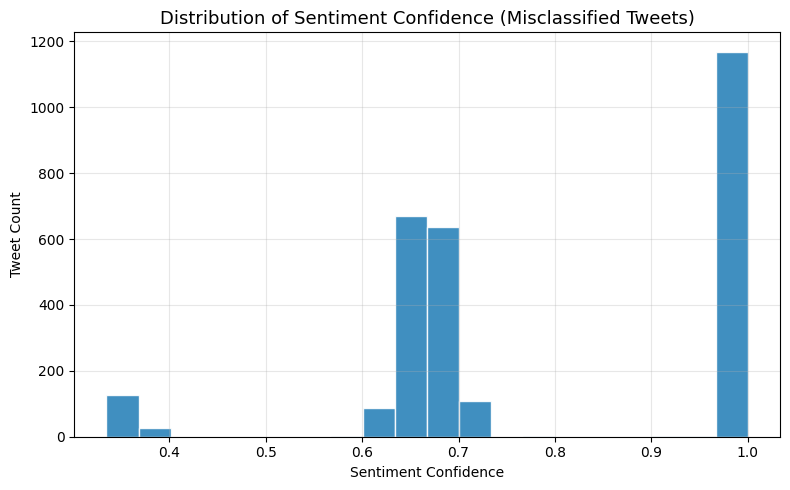

In [4]:
# plot: the distribution of the confidence level of the misclassified cluster
plt.figure(figsize=(8,5))
plt.hist(df_misclassified["sentiment_confidence"], bins=20, color="#2b83ba", edgecolor="white", alpha=0.9)
plt.title("Distribution of Sentiment Confidence (Misclassified Tweets)", fontsize=13)
plt.xlabel("Sentiment Confidence")
plt.ylabel("Tweet Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Confusion matrix (counts):
 pred_label         negative  neutral  positive
airline_sentiment                             
negative               7747     1134       297
neutral                 566     2043       490
positive                121      221      2020

Confusion matrix (row-normalized):
 pred_label         negative  neutral  positive
airline_sentiment                             
negative              0.844    0.124     0.032
neutral               0.183    0.659     0.158
positive              0.051    0.094     0.855


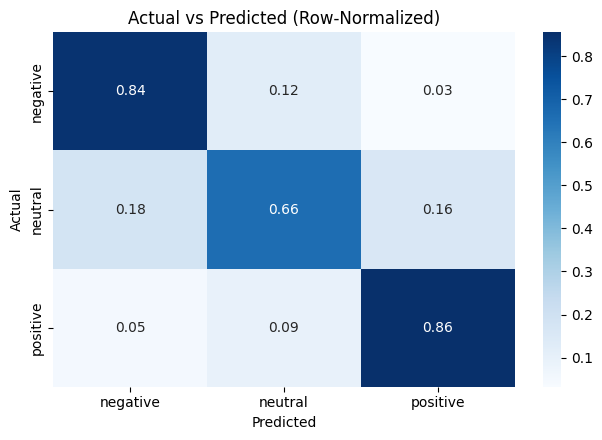

In [5]:
# Confusion (actual rows × predicted cols)
labels_order = sorted(df["airline_sentiment"].unique())  # ['negative','neutral','positive'] typically
cm = pd.crosstab(df["airline_sentiment"], df["pred_label"])  # counts
cm_norm = cm.div(cm.sum(axis=1), axis=0)                   # row-normalized (%)

print("Confusion matrix (counts):\n", cm)
print("\nConfusion matrix (row-normalized):\n", cm_norm.round(3))

plt.figure(figsize=(6.5, 4.5))
sns.heatmap(cm_norm.loc[labels_order], annot=True, fmt=".2f", cmap="Blues")
plt.title("Actual vs Predicted (Row-Normalized)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()